In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime

Метрика: средний доход от пользователя за 1 неделю после первого показа ему рекомендации на 10% (после начала A/B теста время первого показа ищется снова)

Важная информация:
Эксперимент начинается 2023-05-01. Данные есть до 2023-06-01 (но можно завершить раньше, если это позволит оценка длительности)
Вам сказали, что его длительность должна составить 1 месяц.
Все покупки, которые вызваны не влиянием рекомендаций, в этом логе не учитываются

Описание данных:
id_product -  идентификатор продукта, который был рекомендован
is_pay - купил ли пользователь товар
sum_payment - размер платежа (0, если не купил)
city - город, в котором находится пользователь
id_user - пользователь
timestamp - timestamp события
date - дата события

Задачи, которые необходимо решить:
Оценить длительность теста на момент его начала. Сравнить с предложенной. Для оценки необходимо использовать данные с пред экспериментального периода. Посмотреть, есть ли выбросы в данных.
Построить методику расчета целевой метрики. Рассчитать целевую метрику на день окончания теста (рассчитанной в п1) для группы A и B, рассчитать эффект, p_value. Посмотреть, есть ли выбросы в данных.
Рассчитать метрики из п2 по дням и построить их графики.
Принять решение о результате теста - обосновать.

Дополнительно:
При подсчете метрик обработать выбросы в данных - описать почему их можно удалить из теста, если они удаляются. Пожалуйста, не заглядывайте в будущее по данным, если рассчитанная длительность меньше предоставленных данных.

In [18]:
df = pd.read_csv("ab_made_4.gzip", compression='gzip')
df['is_test'] = df['date'].apply(lambda x: x.split('-')[1][1]=='5')
df.tail()

,timestamp,id_user,sum_payment,group,city,id_product,is_pay,date,is_test
56400,1685485266,user_10740,0,A,Санкт-Петербург,14.0,0,2023-05-31,True
56401,1685481632,user_3589,0,B,Санкт-Петербург,1.0,0,2023-05-31,True
56402,1685514383,user_10664,13,A,Москва,17.0,1,2023-05-31,True
56403,1685481325,user_3537,0,B,Ярославь,19.0,0,2023-05-31,True
56404,1685528033,user_6637,0,B,Москва,19.0,0,2023-05-31,True


In [19]:
df_train =df[df['group']=='A'] 
df_test = df[df['group']=='B']

In [20]:
len(df_train), len(df_test) # only old users

(15389, 15257)

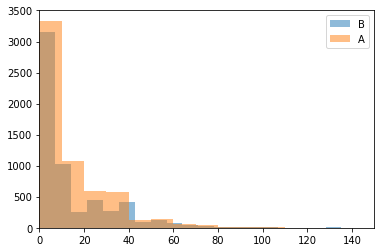

In [21]:
def metric(df, before=False):
    dates = df.groupby('id_user')['date'].min()
    dates_begin = pd.DataFrame(dates).reset_index()
    dates_begin.rename(columns={'date': 'start'}, inplace=True)
    dates_begin['start'] = pd.to_datetime(dates_begin['start'])
    dates_begin['end'] = dates_begin['start'].apply(lambda x: x + datetime.timedelta(days=7))
    if before:
        dates_begin = dates_begin[dates_begin['start'] < before]
    ddf = df.merge(dates_begin, left_on='id_user', right_on='id_user', how='left')
    return ddf[ddf['date'].between(ddf['start'], ddf['end'])].groupby('id_user')['sum_payment'].sum().reset_index()

m = metric(df_test)
weeks_b = m['sum_payment'].values
ma = metric(df_train)
weeks_a = ma['sum_payment'].values
plt.hist(weeks_b, bins=25, alpha=0.5, label='B')
plt.hist(weeks_a, bins=100, alpha=0.5, label='A')
plt.xlim(0, 150)
plt.legend()

In [22]:
np.mean(weeks_b) - np.mean(weeks_a),  (np.mean(weeks_b) - np.mean(weeks_a))/ np.mean(weeks_a)# effect

(0.841333333333333, 0.06661564042334184)

In [31]:
from scipy.stats import ttest_ind

In [32]:
ttest_ind(weeks_b, weeks_a, alternative='less') 

Ttest_indResult(statistic=2.074391270327744, pvalue=0.9809673592430435)

In [33]:
ttest_ind(weeks_b, weeks_a, alternative='greater') 

Ttest_indResult(statistic=2.074391270327744, pvalue=0.019032640756956504)

In [34]:
p_values = []
for d in sorted(list(set(pd.to_datetime(df_test['date']).values))):
    weeks_b = metric(df_test, d)['sum_payment'].values
    p_values.append(ttest_ind(weeks_b, weeks_a, alternative='greater').pvalue)
#     p_values.append(ttest_ind(weeks_b, weeks_a, alternative='two-sided').pvalue)

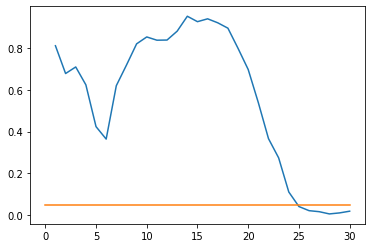

In [40]:
plt.plot(list(range(len(p_values))), p_values)
plt.plot([0, 30], [0.05, 0.05]) # no less 7 days